In [1]:
# libraries
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn import preprocessing

In [2]:
# setting random seed
random_seed = 77
np.random.seed(random_seed)
tf.set_random_seed(random_seed)

In [3]:
# paths
train_data_path = "./data/train_data.npy"
train_label_path = "./data/train_label.npy"
test_data_path = "./data/test_data.npy"
test_label_path = "./data/test_label.npy"

In [4]:
# constants
test_size = 0.1
lr = 0.0002
batch_size = 100
epochs = 300
keep_probab = 1.0
image_shape = (32, 32, 3)
n_classes = 43

In [5]:
# reading data
data_features = np.load(train_data_path)
data_labels = np.load(train_label_path)

In [6]:
# normalizing data
scaler = preprocessing.StandardScaler()
scaler.fit(data_features)
data_features = scaler.transform(data_features)
data_features = np.reshape(data_features, (len(data_features), 32, 32, 3))

/usr/local/lib/python2.7/dist-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype uint8 was converted to float64 by StandardScaler.
  warnings.warn(msg, _DataConversionWarning)


In [7]:
# dividing data into train and validation
X_train, X_val, Y_train, Y_val = train_test_split(data_features, data_labels, test_size=test_size, stratify=data_labels)

In [8]:
# status of data after various different image augmentation operations
# like rotation by 45 degree, image noising, gaussian blurring
# addition of cropped image
n_train = X_train.shape[0]
n_test = X_val.shape[0]
print("Number of training examples: " + str(n_train))
print("Number of test examples: " + str(n_test))
print("Image shape: " + str(image_shape))
print("Number of unique classes: " + str(n_classes))

Number of training examples: 52340
Number of test examples: 5816
Image shape: (32, 32, 3)
Number of unique classes: 43


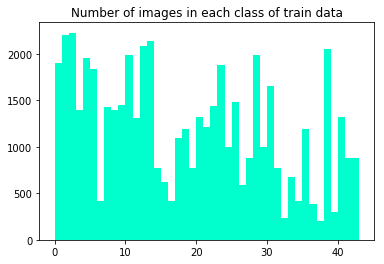

In [9]:
# plot for checking number of images in each class of train data
plt.hist(Y_train, bins=range(44), color='#00ffCC')
plt.title("Number of images in each class of train data")
plt.show()

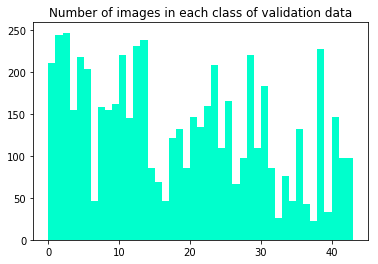

In [10]:
# plot for checking number of images in each class of train data
plt.hist(Y_val, bins=range(44), color='#00ffCC')
plt.title("Number of images in each class of validation data")
plt.show()

In [11]:
# converting labels into one_hot_vector
Y_train_one_hot = pd.get_dummies(pd.Series(Y_train))
Y_val_one_hot = pd.get_dummies(pd.Series(Y_val))

In [12]:
# weight function
def weight_variable(shape):
    init = tf.truncated_normal(shape=shape)
    return tf.Variable(init)

In [13]:
# bias function
def bias_variable(shape):
    init = tf.truncated_normal(shape=shape)
    return tf.Variable(init)

In [14]:
# convolution function
def conv2d(x, W):
    return tf.nn.conv2d(input=x, filter=W, strides=[1,1,1,1], padding='SAME')

In [15]:
# max-pooling functon
def max_pool(x):
    return tf.nn.max_pool(x, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')

In [16]:
## Network Architecture
# input layer
X = tf.placeholder(tf.float32, [None, 32, 32, 3])
Y = tf.placeholder(tf.float32, [None, n_classes])
keep_prob = tf.placeholder(tf.float32)

# first convolutional layer
w_conv1 = weight_variable([3, 3, 3, 32])
b_conv1 = bias_variable([32])
h_conv1 = tf.nn.relu(conv2d(X, w_conv1) + b_conv1)
h_pool1 = max_pool(h_conv1)

# second convolutional layer
w_conv2 = weight_variable([3, 3, 32, 64])
b_conv2 = bias_variable([64])
h_conv2 = tf.nn.relu(conv2d(h_pool1, w_conv2) + b_conv2)
h_pool2 = max_pool(h_conv2)

# third convolutional layer
w_conv3 = weight_variable([3, 3, 64, 128])
b_conv3 = bias_variable([128])
h_conv3 = tf.nn.relu(conv2d(h_pool2, w_conv3) + b_conv3)
h_pool3 = max_pool(h_conv3)
h_pool3_flat = tf.reshape(h_pool3, [-1, 4 * 4 * 128])

# fully connected layer
w_fc1 = weight_variable([4 * 4 * 128, 1024])
b_fc1 = bias_variable([1024])
h_fc1 = tf.nn.relu(tf.matmul(h_pool3_flat, w_fc1) + b_fc1)

# dropout layer
h_fc1_dropout = tf.nn.dropout(h_fc1, keep_prob)

# output layer
w_fc2 = weight_variable([1024, n_classes])
b_fc2 = bias_variable([n_classes])
out = tf.add(tf.matmul(h_fc1_dropout, w_fc2), b_fc2)

# getting predictions
pred_step = tf.argmax(out, 1)

# cost and optimizer
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=out, labels=Y))
optimizer = tf.train.AdamOptimizer(lr).minimize(cost)

# evaluation step
matches = tf.equal(tf.argmax(out, 1), tf.argmax(Y, 1))
accuracy = tf.reduce_mean(tf.cast(matches, tf.float32))

# initializing session
init = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init)

In [17]:
# training network
e = 0
while(e < epochs):
	# batch pointer
	batch_start = 0
	batch_end = batch_size
	# training in batches
	while(batch_end <= len(X_train)):
		# making batch
		X_batch = X_train[batch_start : batch_end]
		Y_batch = Y_train_one_hot[batch_start : batch_end]
		# training step
		sess.run(optimizer, feed_dict={X: X_batch, Y: np.array(Y_batch), keep_prob: keep_probab})
		# updating batch pointers
		batch_start = batch_end
		batch_end = batch_end + batch_size
		if(batch_start < len(X_train) and batch_end > len(X_train)):
			batch_end = len(X_train)
	# batch pointer
	batch_start = 0
	batch_end = batch_size
	# finding train accuracy in batches
	eval_batch_size = len(X_val)
	train_loss = 0
	train_matches = 0
	while(batch_end <= len(X_train)):
		# making batch
		X_batch = X_train[batch_start : batch_end]
		Y_batch = Y_train_one_hot[batch_start : batch_end]
		# getting train accuracy
		loss, mat = sess.run([cost, matches], feed_dict={X: X_batch, Y: np.array(Y_batch), keep_prob: keep_probab})
		train_loss = train_loss + loss
		if(batch_start == 0):
			train_matches = mat
		else:
			train_matches = np.concatenate((train_matches, mat))
		# updating batch pointers
		batch_start = batch_end
		batch_end = batch_end + eval_batch_size
		if(batch_start < len(X_train) and batch_end > len(X_train)):
			batch_end = len(X_train)
	# calculating training loss and training accuracy
	train_loss = train_loss / float(len(X_train)/float(eval_batch_size))
	train_acc = np.mean(train_matches)
	print("Train:  Epoch="+str(e)+"  TrainLoss="+str(train_loss)+"  TrainAcc="+str(train_acc))
	# getting validation accuracy
	loss, acc = sess.run([cost, accuracy], feed_dict={X: X_val, Y: np.array(Y_val_one_hot), keep_prob: keep_probab})
	print("Valid:  Epoch="+str(e)+"  ValidLoss="+str(loss)+"  ValAcc="+str(acc))
	print
	# updating epoch
	e = e + 1

Train:  Epoch=0  TrainLoss=172364.930385  TrainAcc=0.169373328238
Valid:  Epoch=0  ValidLoss=157166.0  ValAcc=0.165922

Train:  Epoch=1  TrainLoss=100464.035722  TrainAcc=0.273232709209
Valid:  Epoch=1  ValidLoss=93755.4  ValAcc=0.268741

Train:  Epoch=2  TrainLoss=69030.6414716  TrainAcc=0.351910584639
Valid:  Epoch=2  ValidLoss=65482.9  ValAcc=0.347318

Train:  Epoch=3  TrainLoss=51410.9547406  TrainAcc=0.41079480321
Valid:  Epoch=3  ValidLoss=49953.0  ValAcc=0.399587

Train:  Epoch=4  TrainLoss=40377.9805514  TrainAcc=0.462399694306
Valid:  Epoch=4  ValidLoss=40112.2  ValAcc=0.44945

Train:  Epoch=5  TrainLoss=32528.1424048  TrainAcc=0.503725640046
Valid:  Epoch=5  ValidLoss=33279.7  ValAcc=0.484869

Train:  Epoch=6  TrainLoss=26693.6726774  TrainAcc=0.547688192587
Valid:  Epoch=6  ValidLoss=28256.0  ValAcc=0.524072

Train:  Epoch=7  TrainLoss=22192.3538713  TrainAcc=0.583683607184
Valid:  Epoch=7  ValidLoss=24423.4  ValAcc=0.548315

Train:  Epoch=8  TrainLoss=18622.6439084  TrainAc

Train:  Epoch=69  TrainLoss=79.3588713492  TrainAcc=0.98528849828
Valid:  Epoch=69  ValidLoss=3112.94  ValAcc=0.898555

Train:  Epoch=70  TrainLoss=66.817091014  TrainAcc=0.986836071838
Valid:  Epoch=70  ValidLoss=2951.05  ValAcc=0.902854

Train:  Epoch=71  TrainLoss=73.8737525167  TrainAcc=0.986071837982
Valid:  Epoch=71  ValidLoss=2964.48  ValAcc=0.903714

Train:  Epoch=72  TrainLoss=110.73771459  TrainAcc=0.982288880397
Valid:  Epoch=72  ValidLoss=3084.76  ValAcc=0.897868

Train:  Epoch=73  TrainLoss=88.5157681148  TrainAcc=0.985231180741
Valid:  Epoch=73  ValidLoss=2948.53  ValAcc=0.898384

Train:  Epoch=74  TrainLoss=139.735910718  TrainAcc=0.980320978219
Valid:  Epoch=74  ValidLoss=3123.87  ValAcc=0.894773

Train:  Epoch=75  TrainLoss=99.0686421903  TrainAcc=0.988632021399
Valid:  Epoch=75  ValidLoss=3089.65  ValAcc=0.898727

Train:  Epoch=76  TrainLoss=55.0104607156  TrainAcc=0.989358043561
Valid:  Epoch=76  ValidLoss=2893.85  ValAcc=0.901994

Train:  Epoch=77  TrainLoss=51.1851

Train:  Epoch=137  TrainLoss=18.7560641759  TrainAcc=0.996446312572
Valid:  Epoch=137  ValidLoss=2131.75  ValAcc=0.930364

Train:  Epoch=138  TrainLoss=19.9933675708  TrainAcc=0.996274359954
Valid:  Epoch=138  ValidLoss=2144.92  ValAcc=0.931568

Train:  Epoch=139  TrainLoss=19.6161100049  TrainAcc=0.995949560566
Valid:  Epoch=139  ValidLoss=2094.61  ValAcc=0.93002

Train:  Epoch=140  TrainLoss=26.608528368  TrainAcc=0.996369889186
Valid:  Epoch=140  ValidLoss=2203.33  ValAcc=0.935007

Train:  Epoch=141  TrainLoss=28.6122053106  TrainAcc=0.994745892243
Valid:  Epoch=141  ValidLoss=2058.53  ValAcc=0.929161

Train:  Epoch=142  TrainLoss=8.2012841162  TrainAcc=0.997955674436
Valid:  Epoch=142  ValidLoss=1982.53  ValAcc=0.935522

Train:  Epoch=143  TrainLoss=9.39895194993  TrainAcc=0.998280473825
Valid:  Epoch=143  ValidLoss=2014.12  ValAcc=0.935351

Train:  Epoch=144  TrainLoss=16.4573970924  TrainAcc=0.997286969813
Valid:  Epoch=144  ValidLoss=2118.51  ValAcc=0.930364

Train:  Epoch=145  

Train:  Epoch=204  TrainLoss=4.31507363704  TrainAcc=0.999254871991
Valid:  Epoch=204  ValidLoss=1621.09  ValAcc=0.946355

Train:  Epoch=205  TrainLoss=11.3679499026  TrainAcc=0.998528849828
Valid:  Epoch=205  ValidLoss=1756.44  ValAcc=0.946698

Train:  Epoch=206  TrainLoss=10.104524882  TrainAcc=0.99772640428
Valid:  Epoch=206  ValidLoss=1651.0  ValAcc=0.946698

Train:  Epoch=207  TrainLoss=43.5950984236  TrainAcc=0.992625143294
Valid:  Epoch=207  ValidLoss=1808.7  ValAcc=0.939305

Train:  Epoch=208  TrainLoss=10.0095893627  TrainAcc=0.998242262132
Valid:  Epoch=208  ValidLoss=1723.43  ValAcc=0.944119

Train:  Epoch=209  TrainLoss=5.89150154624  TrainAcc=0.998605273214
Valid:  Epoch=209  ValidLoss=1727.3  ValAcc=0.945667

Train:  Epoch=210  TrainLoss=16.541485274  TrainAcc=0.996446312572
Valid:  Epoch=210  ValidLoss=1684.21  ValAcc=0.943604

Train:  Epoch=211  TrainLoss=27.2718937741  TrainAcc=0.99793656859
Valid:  Epoch=211  ValidLoss=1773.92  ValAcc=0.945151

Train:  Epoch=212  Trai

Train:  Epoch=271  TrainLoss=9.97573229083  TrainAcc=0.998509743982
Valid:  Epoch=271  ValidLoss=1529.15  ValAcc=0.949621

Train:  Epoch=272  TrainLoss=2.67411523868  TrainAcc=0.999579671379
Valid:  Epoch=272  ValidLoss=1343.22  ValAcc=0.954092

Train:  Epoch=273  TrainLoss=0.433727453218  TrainAcc=0.999732518151
Valid:  Epoch=273  ValidLoss=1363.72  ValAcc=0.953576

Train:  Epoch=274  TrainLoss=1.36382176267  TrainAcc=0.999656094765
Valid:  Epoch=274  ValidLoss=1451.68  ValAcc=0.951169

Train:  Epoch=275  TrainLoss=15.7680396378  TrainAcc=0.998223156286
Valid:  Epoch=275  ValidLoss=1587.34  ValAcc=0.948246

Train:  Epoch=276  TrainLoss=23.5586814065  TrainAcc=0.998070309515
Valid:  Epoch=276  ValidLoss=1608.36  ValAcc=0.950825

Train:  Epoch=277  TrainLoss=5.28653473021  TrainAcc=0.998700802446
Valid:  Epoch=277  ValidLoss=1409.08  ValAcc=0.954092

Train:  Epoch=278  TrainLoss=4.03896090858  TrainAcc=0.998891860909
Valid:  Epoch=278  ValidLoss=1381.37  ValAcc=0.954952

Train:  Epoch=2

In [18]:
# reading test data, 5 images
test_data = np.load(test_data_path)
test_label = np.load(test_label_path)

In [19]:
# normalizing test data
test_data = scaler.transform(test_data)
test_data = np.reshape(test_data, (len(test_data), 32, 32, 3))
print("Shape of test data: " + str(test_data.shape))

Shape of test data: (5, 32, 32, 3)


In [20]:
# getting test accuracy
test_pred = sess.run(pred_step, feed_dict = {X: test_data, keep_prob: keep_probab})
test_accuracy = accuracy_score(test_pred, test_label)
print("Test Accuracy: " + str(test_accuracy))

Test Accuracy: 0.0


In [21]:
# getting top 5 predicted classes for test images
test_pred_prob = sess.run(out, feed_dict={X: test_data, keep_prob: keep_probab})
top_k = sess.run(tf.nn.top_k(test_pred_prob, k=5, sorted=True))
print(top_k)

TopKV2(values=array([[ 263059.5     ,  177488.328125,  153980.90625 ,  151166.671875,
         115443.15625 ],
       [ 272456.      ,  227229.109375,  207690.625   ,  183878.3125  ,
         157665.484375],
       [ 188688.578125,  177094.875   ,  171138.9375  ,  137037.859375,
         135236.734375],
       [ 307451.1875  ,  293140.375   ,  264120.125   ,  251648.359375,
         181204.46875 ],
       [ 385609.8125  ,  283905.375   ,  186123.640625,  166877.328125,
         162580.859375]], dtype=float32), indices=array([[36, 13, 25, 42, 37],
       [35, 13, 40, 10, 38],
       [10, 25, 40,  1, 18],
       [25,  0, 13, 16, 31],
       [37, 25, 39,  0, 23]], dtype=int32))
